# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [7]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [6]:
# There were an error in hog_feature, I corrected it by replacing
# orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[cx/2::cx, cy/2::cy].T
# by
# orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[int(cx/2)::cx, int(cy/2)::cy].T
# It's probably because it has been done in an earlier version of python in which cx/2 was an integer.

def hog_feature(im):
  """Compute Histogram of Gradient (HOG) feature for an image
  
       Modified from skimage.feature.hog
       http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog
     
     Reference:
       Histograms of Oriented Gradients for Human Detection
       Navneet Dalal and Bill Triggs, CVPR 2005
     
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (HOG) feature
    
  """
  
  # convert rgb to grayscale if needed
  if im.ndim == 3:
    image = rgb2gray(im)
  else:
    image = np.at_least_2d(im)

  sx, sy = image.shape # image size
  orientations = 9 # number of gradient bins
  cx, cy = (8, 8) # pixels per cell

  gx = np.zeros(image.shape)
  gy = np.zeros(image.shape)
  gx[:, :-1] = np.diff(image, n=1, axis=1) # compute gradient on x-direction
  gy[:-1, :] = np.diff(image, n=1, axis=0) # compute gradient on y-direction
  grad_mag = np.sqrt(gx ** 2 + gy ** 2) # gradient magnitude
  grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90 # gradient orientation

  n_cellsx = int(np.floor(sx / cx))  # number of cells in x
  n_cellsy = int(np.floor(sy / cy))  # number of cells in y
  # compute orientations integral images
  orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
  for i in range(orientations):
    # create new integral image for this orientation
    # isolate orientations in this range
    temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                        grad_ori, 0)
    temp_ori = np.where(grad_ori >= 180 / orientations * i,
                        temp_ori, 0)
    # select magnitudes for those orientations
    cond2 = temp_ori > 0
    temp_mag = np.where(cond2, grad_mag, 0)
    
    #there's an error here
    print(i, cx, cy, cx/2, cy/2)
    orientation_histogram[:,:,i] = uniform_filter(temp_mag, size=(cx, cy))[int(cx/2)::cx, int(cy/2)::cy].T
  
  return orientation_histogram.ravel()

hog_feature(X_train[1])

(32, 32, 3)
0 8 8 4.0 4.0
1 8 8 4.0 4.0
2 8 8 4.0 4.0
3 8 8 4.0 4.0
4 8 8 4.0 4.0
5 8 8 4.0 4.0
6 8 8 4.0 4.0
7 8 8 4.0 4.0
8 8 8 4.0 4.0


array([  2.95525891e+00,   8.71562180e-01,   4.92904588e-01,
         7.43630077e-01,   1.14752421e+00,   6.13361576e-01,
         2.75789027e+00,   3.61016411e+00,   5.85810192e-01,
         1.11022302e-16,   8.11730301e-01,   7.22584696e-01,
         7.30781729e-01,   2.73582224e+00,   1.42466952e+00,
         3.64121634e+00,   7.07759570e+00,   5.97764895e+00,
         3.41259692e+00,   2.03613978e+00,   1.64633975e-02,
         1.69773870e+00,   1.89056417e+00,   3.12436846e+00,
         0.00000000e+00,   1.76323267e+00,   3.07532123e+00,
         1.30376628e+01,   1.09629761e-01,   1.22043605e-01,
         1.31619706e-01,   1.97018750e+00,   1.66533454e-16,
         0.00000000e+00,   1.28395345e+00,   1.30268944e+01,
         3.44009394e+00,   5.00832055e+00,   3.50190176e+00,
         0.00000000e+00,   4.76773334e+00,   1.20992484e+00,
         1.15653249e+00,   8.56124516e+00,   9.41643456e+00,
         0.00000000e+00,   0.00000000e+00,   2.24688587e-01,
         1.24890583e+00,

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=1500, verbose=False)
        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        acc_train = np.mean(y_train == svm.predict(X_train_feats))
        results[(learning_rate, reg)] = (acc_train,acc_val)
        if (acc_val > best_val):
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# best results for lr -07 

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.113571 val accuracy: 0.117000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.099388 val accuracy: 0.105000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.305510 val accuracy: 0.333000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.116286 val accuracy: 0.122000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.306122 val accuracy: 0.336000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.310612 val accuracy: 0.332000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.306184 val accuracy: 0.340000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.307102 val accuracy: 0.334000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.277898 val accuracy: 0.307000
best validation accuracy achieved during cross-validation: 0.340000


In [9]:
learning_rates = [1e-7, 1e-6, 1e-5]
regularization_strengths = [5e3, 5e4, 5e5, 5e6, 5e7]
results = {}
best_val = -1
best_svm = None

for learning_rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=1500, verbose=False)
        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        acc_train = np.mean(y_train == svm.predict(X_train_feats))
        results[(learning_rate, reg)] = (acc_train,acc_val)
        if (acc_val > best_val):
            best_val = acc_val
            best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# best results for lr e-7, reg between [5e4,5e6], and lr e-6, reg between [5e3,5e5], and lr e-5, reg= 5e3

C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:109: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W # add regularization
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:84: RuntimeWarning: invalid value encountered in maximum
  np.maximum(margin, 0, margin) # keep only positive term, in-place function
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_classifier.py:73: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate*grad
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:83: RuntimeWarning: invalid value encountered in subtract
  margin = scores - correct_class_score + 1 # matrix NxC. However, we get 1 rather than 0 for correct_class


lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.135776 val accuracy: 0.121000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.309735 val accuracy: 0.338000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.295918 val accuracy: 0.336000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.284673 val accuracy: 0.323000
lr 1.000000e-07 reg 5.000000e+07 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.308000 val accuracy: 0.336000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.309755 val accuracy: 0.340000
lr 1.000000e-06 reg 5.000000e+05 train accuracy: 0.282143 val accuracy: 0.315000
lr 1.000000e-06 reg 5.000000e+06 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-06 reg 5.000000e+07 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-05 reg 5.000000e+03 train accuracy: 0.309102 val accuracy: 0.335000
lr 1.000000e-05 reg 5.000000e+04 train accuracy: 0.272429 val accuracy: 0.298000
lr 1.000000e-05 reg 5.000000

In [11]:
learning_rates = 1e-7*np.arange(1,11,2)
print(learning_rates)
regularization_strengths = 5*10**np.arange(3,6,0.6)
print(regularization_strengths)
results = {}
best_val = -1
best_svm = None

for learning_rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=1500, verbose=False)
        y_val_pred = svm.predict(X_val_feats)
        acc_val = np.mean(y_val == y_val_pred)
        acc_train = np.mean(y_train == svm.predict(X_train_feats))
        results[(learning_rate, reg)] = (acc_train,acc_val)
        if (acc_val > best_val):
            best_val = acc_val
            best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


[  1.00000000e-07   3.00000000e-07   5.00000000e-07   7.00000000e-07
   9.00000000e-07]
[    5000.            19905.35852767    79244.65962306   315478.6722401
  1255943.21575479]
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.152959 val accuracy: 0.156000
lr 1.000000e-07 reg 1.990536e+04 train accuracy: 0.309592 val accuracy: 0.338000
lr 1.000000e-07 reg 7.924466e+04 train accuracy: 0.308306 val accuracy: 0.334000
lr 1.000000e-07 reg 3.154787e+05 train accuracy: 0.305245 val accuracy: 0.334000
lr 1.000000e-07 reg 1.255943e+06 train accuracy: 0.300755 val accuracy: 0.328000
lr 3.000000e-07 reg 5.000000e+03 train accuracy: 0.303694 val accuracy: 0.333000
lr 3.000000e-07 reg 1.990536e+04 train accuracy: 0.309224 val accuracy: 0.342000
lr 3.000000e-07 reg 7.924466e+04 train accuracy: 0.306184 val accuracy: 0.330000
lr 3.000000e-07 reg 3.154787e+05 train accuracy: 0.298306 val accuracy: 0.335000
lr 3.000000e-07 reg 1.255943e+06 train accuracy: 0.269408 val accuracy: 0.311000
lr 5.00000

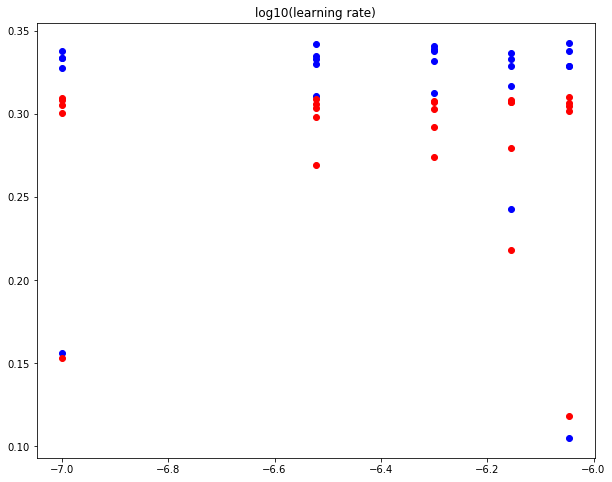

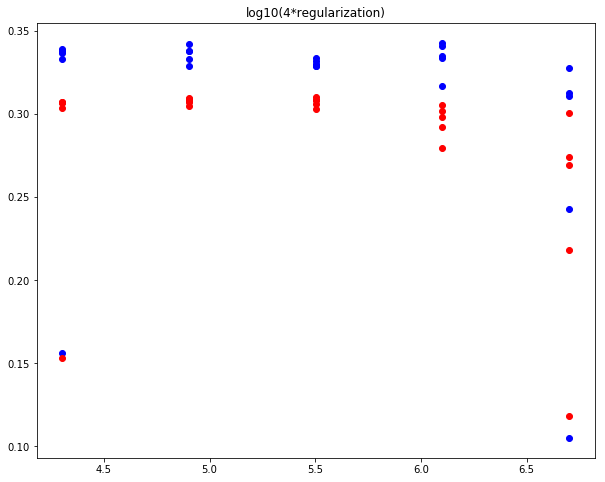

In [13]:
import math as m

lr_list = []
reg_list = []
train_list = []
val_list = []

for keys, values in results.items():
    lr, reg = keys
    acc_val, acc_train = values
    lr_list.append(m.log10(lr))
    reg_list.append(m.log10(4*reg))
    train_list.append(acc_train)
    val_list.append(acc_val)
    
plt.plot(lr_list, train_list, 'bo', lr_list, val_list, 'ro') 
plt.title('log10(learning rate)')
plt.show()
plt.plot(reg_list, train_list, 'bo', reg_list, val_list, 'ro') 
plt.title('log10(4*regularization)')
plt.show()

C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:109: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W # add regularization
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:84: RuntimeWarning: invalid value encountered in maximum
  np.maximum(margin, 0, margin) # keep only positive term, in-place function
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_classifier.py:73: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate*grad
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:83: RuntimeWarning: invalid value encountered in subtract
  margin = scores - correct_class_score + 1 # matrix NxC. However, we get 1 rather than 0 for correct_class


55.3198184967041
best validation accuracy achieved during cross-validation: 0.354000


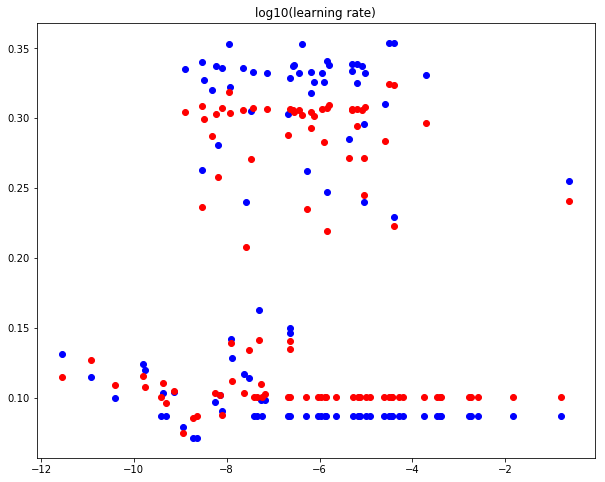

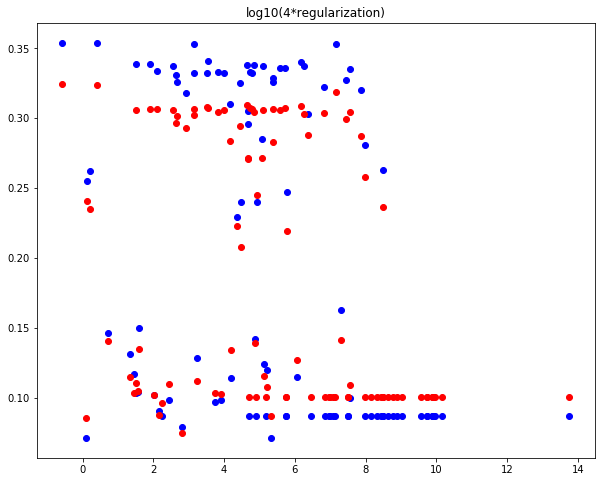

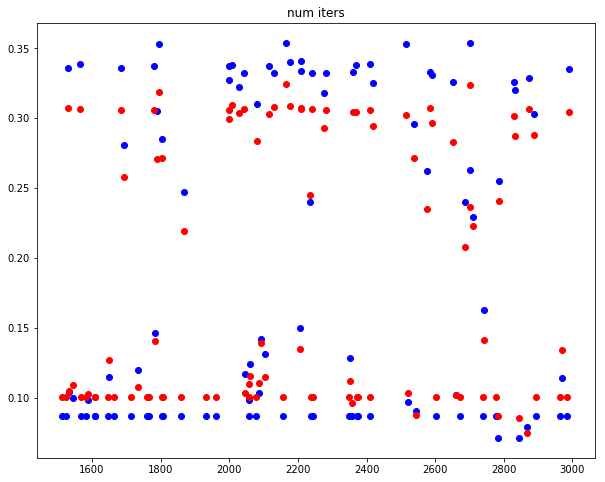

In [15]:
# Do with random
import random
import time
best_net = None # store the best model into this 
results = {}
best_val = -1

startTime = time.time()
for i in range(100):
    lr = 10**(random.normalvariate(-6.5, 2))
    reg = 10**(random.normalvariate(5, 3))
    num_iters = random.randint(1500, 3000)
    
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                  num_iters=num_iters, verbose=False)
    y_val_pred = svm.predict(X_val_feats)
    acc_val = np.mean(y_val == y_val_pred)
    acc_train = np.mean(y_train == svm.predict(X_train_feats))
    results[(lr, reg, num_iters)] = (acc_train,acc_val)
    if (acc_val > best_val):
        best_val = acc_val
        best_svm = svm
print(time.time()-startTime)
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr_list = []
reg_list = []
iters_list = []
train_list = []
val_list = []

for keys, values in results.items():
    lr, reg, num_iters = keys
    acc_val, acc_train = values
    lr_list.append(m.log10(lr))
    reg_list.append(m.log10(reg))
    iters_list.append(num_iters)
    train_list.append(acc_train)
    val_list.append(acc_val)
    
plt.plot(lr_list, train_list, 'bo', lr_list, val_list, 'ro') 
plt.title('log10(learning rate)')
plt.show()
plt.plot(reg_list, train_list, 'bo', reg_list, val_list, 'ro') 
plt.title('log10(regularization)')
plt.show()
plt.plot(iters_list, train_list, 'bo', iters_list, val_list, 'ro') 
plt.title('num iters')
plt.show()

C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:109: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W # add regularization
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:84: RuntimeWarning: invalid value encountered in maximum
  np.maximum(margin, 0, margin) # keep only positive term, in-place function
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_classifier.py:73: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate*grad
C:\Users\nicol\Documents\Python Scripts\Stanford cs231n\assignment1\cs231n\classifiers\linear_svm.py:83: RuntimeWarning: invalid value encountered in subtract
  margin = scores - correct_class_score + 1 # matrix NxC. However, we get 1 rather than 0 for correct_class


55.54828071594238
best validation accuracy achieved during cross-validation: 0.359000


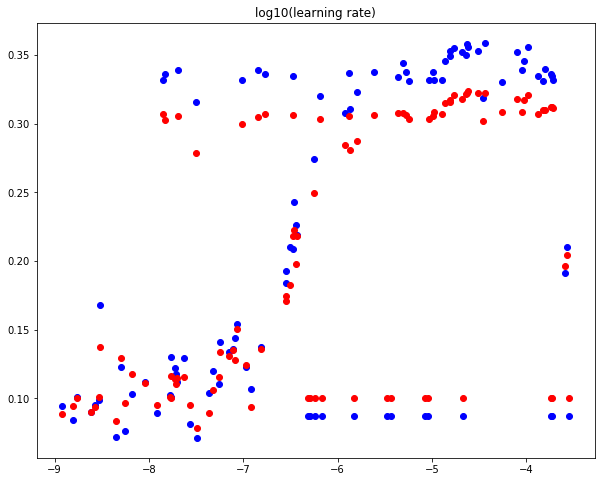

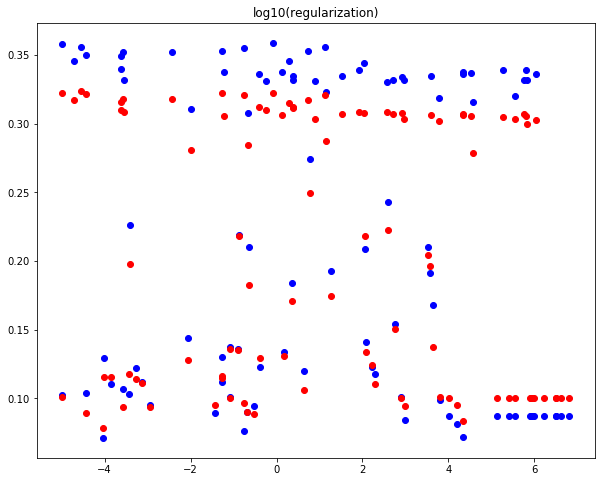

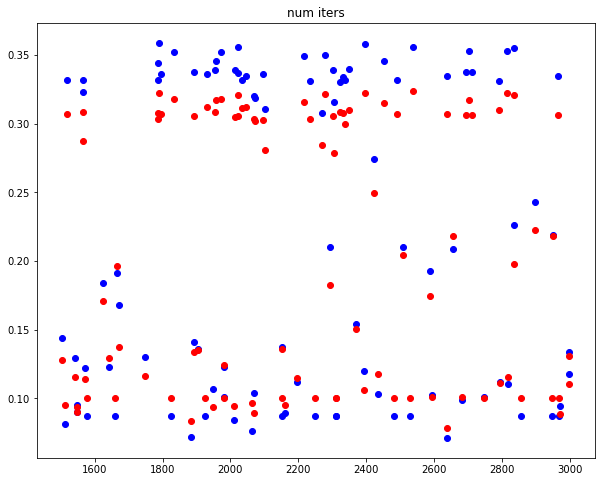

In [17]:
# Do with random
import random
import time
best_net = None # store the best model into this 
results = {}
best_val = -1

startTime = time.time()
for i in range(100):
    lr = 10**(random.uniform(-9., -3.5))
    reg = 10**(random.uniform(-5, 7))
    num_iters = random.randint(1500, 3000)
    
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                  num_iters=num_iters, verbose=False)
    y_val_pred = svm.predict(X_val_feats)
    acc_val = np.mean(y_val == y_val_pred)
    acc_train = np.mean(y_train == svm.predict(X_train_feats))
    results[(lr, reg, num_iters)] = (acc_train,acc_val)
    if (acc_val > best_val):
        best_val = acc_val
        best_svm = svm
print(time.time()-startTime)
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr_list = []
reg_list = []
iters_list = []
train_list = []
val_list = []

for keys, values in results.items():
    lr, reg, num_iters = keys
    acc_val, acc_train = values
    lr_list.append(m.log10(lr))
    reg_list.append(m.log10(reg))
    iters_list.append(num_iters)
    train_list.append(acc_train)
    val_list.append(acc_val)
    
plt.plot(lr_list, train_list, 'bo', lr_list, val_list, 'ro') 
plt.title('log10(learning rate)')
plt.show()
plt.plot(reg_list, train_list, 'bo', reg_list, val_list, 'ro') 
plt.title('log10(regularization)')
plt.show()
plt.plot(iters_list, train_list, 'bo', iters_list, val_list, 'ro') 
plt.title('num iters')
plt.show()

In [18]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.314


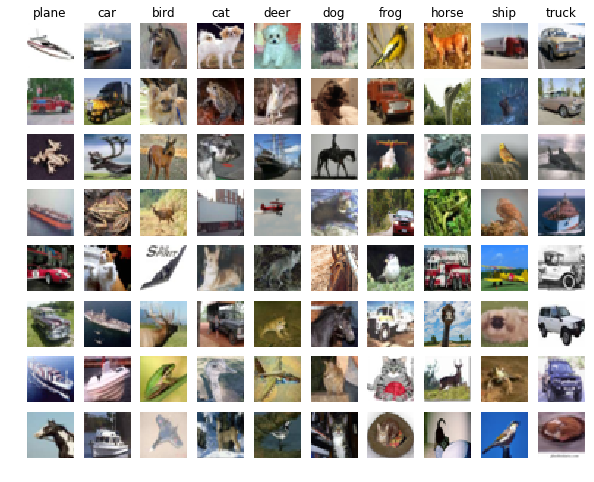

In [19]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Some make sense, like the cars mistaken for trucks and deers mistaken for horses. However, it is not obvious to me why horses
are mistaken for birds or dogs. In general, animals were mistaken for animals and vehicles for vehicles which makes sense. 
Many birds were mistaken for ships, probably because the sky has a similar color to the ocean.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print(X_train_feats.shape)

In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!